# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [24]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

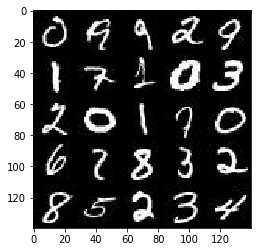

In [25]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

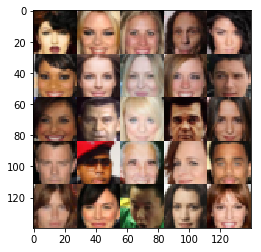

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [54]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 14x14x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        #7x7x256 now
        
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function 
        
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 4x4x256 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 8x8x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 16x16x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:', logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [59]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model   
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 2.5297
Epoch 1/2... Discriminator Loss: 0.4946... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 3.0280
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.2895
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.4693


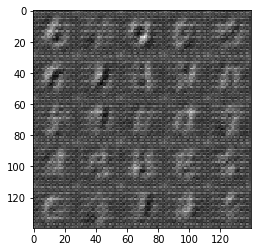

Epoch 1/2... Discriminator Loss: 1.6109... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.9631... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 2.7687
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.4109
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 1.3286


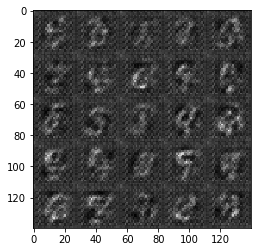

Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 2.0040
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4855
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 3.0945
Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 2.0728
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 2.1440
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.2019


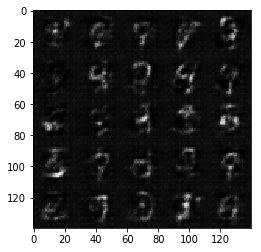

Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 1.2564
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 0.6665... Generator Loss: 2.4520
Epoch 1/2... Discriminator Loss: 0.6589... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 2.8657
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 1.8213
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 2.5414
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 1.7960
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 0.9190


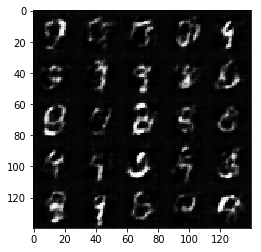

Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.7979
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 2.9403
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.6615
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 1.7792
Epoch 1/2... Discriminator Loss: 0.6485... Generator Loss: 2.3104
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 2.6233
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 2.0621
Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 1.8036
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.5809


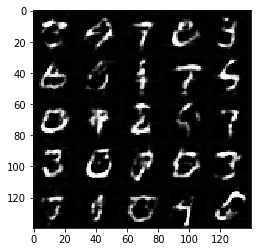

Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 1.9321
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 2.8806
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.1994
Epoch 1/2... Discriminator Loss: 2.5916... Generator Loss: 5.8785
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 2.1708
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.9160


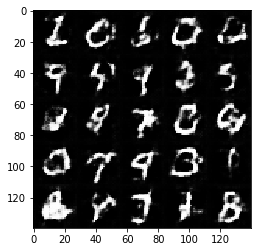

Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.4654
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 2.4157
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.9747
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 2.8745
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 2.2189... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.9507


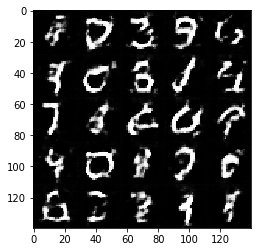

Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 1.6589
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.9049
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.4396
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 2.3861
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 3.1573
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.7022


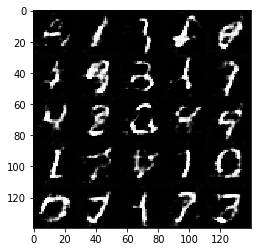

Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.5455
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.4188
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.6274
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.7536


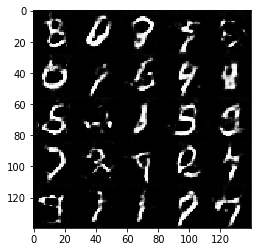

Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.9012
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.5324
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 2.4541
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.9803
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 2.0356
Epoch 2/2... Discriminator Loss: 1.6890... Generator Loss: 3.4983
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.2884


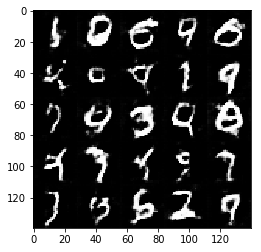

Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.7635
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.6871
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.5547
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 1.1857
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.4815
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 2.3758


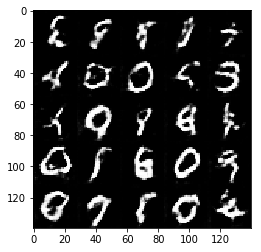

Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.5230
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 2.1802
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.2786
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 2.7042
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.0858


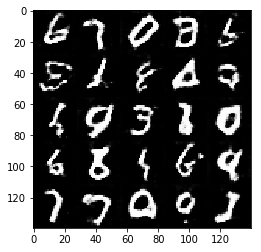

Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.3486
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.4910
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.8993
Epoch 2/2... Discriminator Loss: 2.5540... Generator Loss: 0.1826


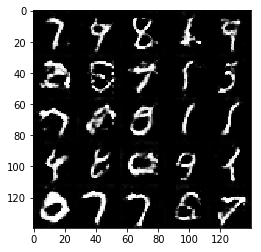

Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.5180
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.8397
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.7546
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 1.7977


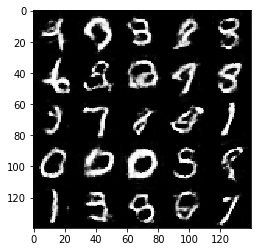

Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.7410
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.5750
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.6529
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.3455


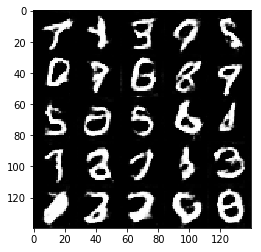

Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 1.6593
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.6552
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.8854
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.9826


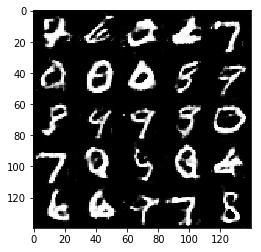

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.7637
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 2.0447
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 2.0525
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 1.4487
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.1668


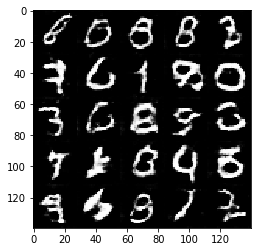

Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.7754
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.8282
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 2.0264
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.2609
Epoch 2/2... Discriminator Loss: 3.5800... Generator Loss: 4.5366
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.3033


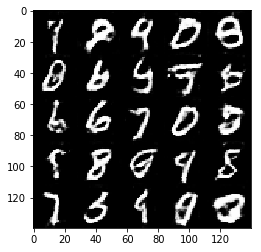

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.1522
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 2.8162
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.5079


In [60]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.6529
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.1446
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 3.1188
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 2.5308
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 4.6122
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 10.8783
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 6.9344
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 4.4928
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.4943


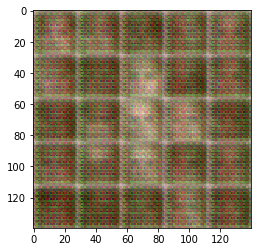

Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 2.4768
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 2.0045
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 2.1322
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.5121
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 2.4367
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.4817
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.6726


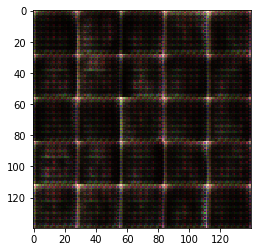

Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 2.9507
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.7826
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 3.9017


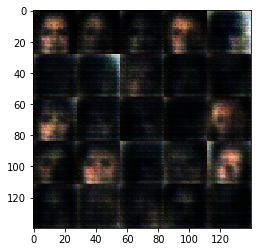

Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 2.4893
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 3.0243
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.8528
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.9484


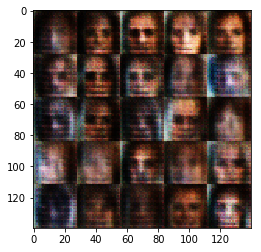

Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 2.3732
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.9332


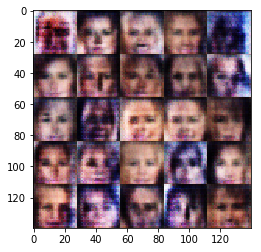

Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 2.1322
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 2.2185
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.7940


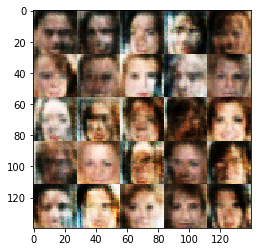

Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 2.1206
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.7442
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 2.3328
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 2.8867


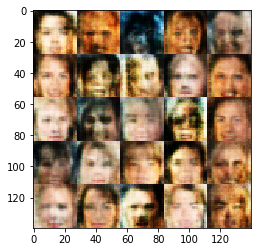

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 2.6077
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.2904


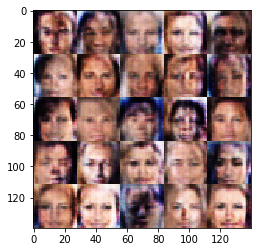

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.9376
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.2120


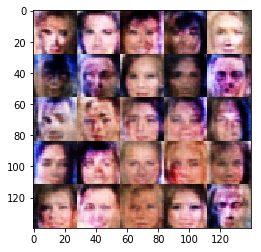

Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.2073


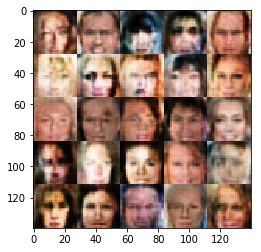

Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 2.2042
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 2.2663
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.9280
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.8118


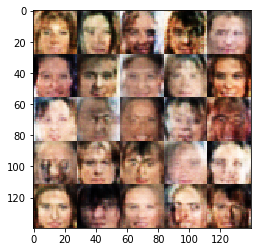

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 2.2070
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0014


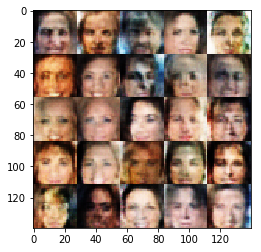

Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 2.3171
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 1.7947
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.0458


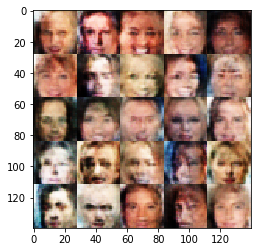

Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.0325


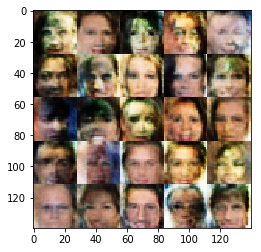

Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.7165
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.8659
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5381


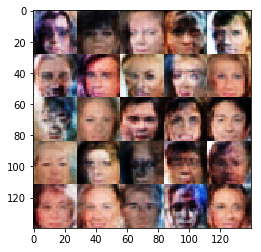

Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 2.2499
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8410


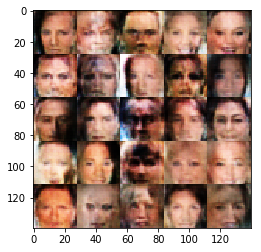

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.9876
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.6502


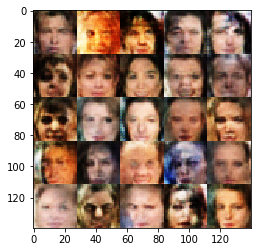

Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6418


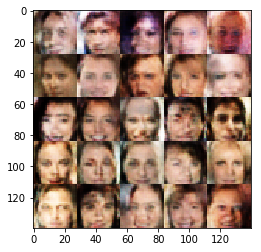

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.9663
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.0641


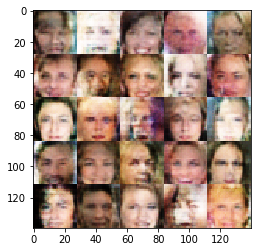

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.1612


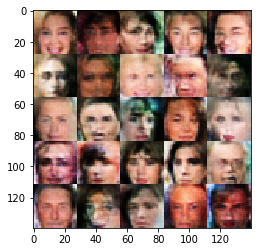

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 2.6692
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 2.7530


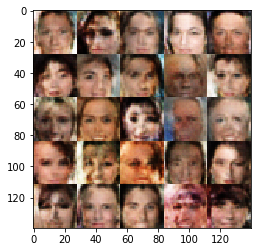

Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 2.1195


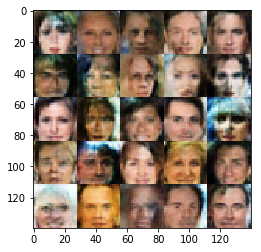

Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 2.1147
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 2.1785
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.9845
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.3765


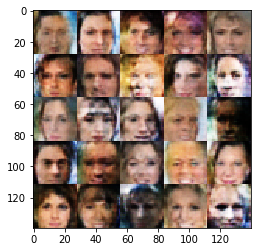

Epoch 1/1... Discriminator Loss: 1.6721... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 2.0106
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 1.5787


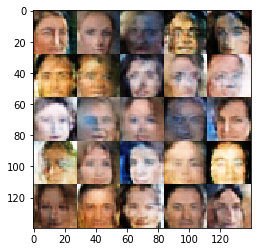

Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1127


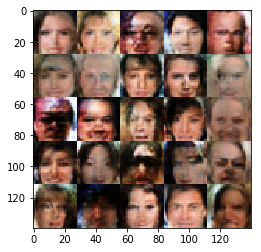

Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.7090


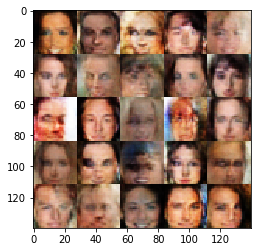

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5732


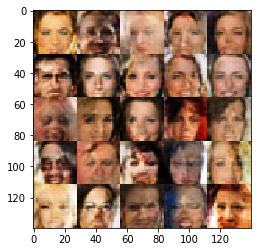

Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.8926


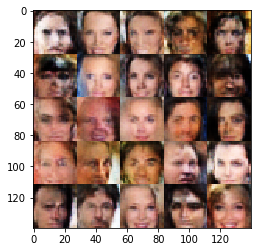

Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.6691
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.7390


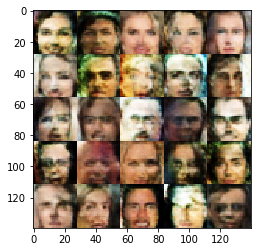

Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.5424
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7871


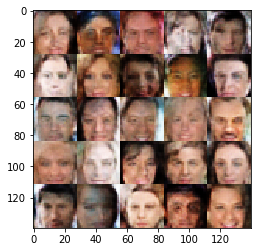

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 2.0819
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.5814


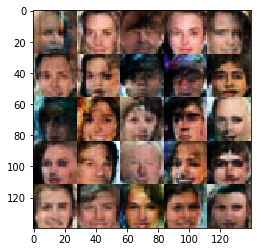

Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.7816


In [61]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.